In [1]:
import os
import numpy as np

import torch as th
from torch.utils.data import DataLoader
import torchvision as tv
from torchvision import datasets, transforms
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
# from safetensors.torch import save_model, load_model

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import trange

from typing import List, Union, Callable, Tuple
from torch import Tensor

# Set the default style
sns.set_theme(
	style="whitegrid",
	palette="tab10",
	rc={
		"grid.linestyle": "--",
		"grid.color": "gray",
		"grid.alpha": 0.3,
		"grid.linewidth": 0.3,
	},
)

# # Constant hyperparameters
DEVICE_AUTODETECT: bool = True
TRAIN_BATCH_SIZE: int = 64	# Batch size for training
TEST_BS: int = 64	# Batch size for testing
EPOCHS: int = 40	# Number of epochs

CRITERION: Union[th.nn.Module, Callable[[th.Tensor], th.Tensor]] = (
    th.nn.CrossEntropyLoss(reduction="mean")
)
EVAL_CRITERION: Union[th.nn.Module, Callable[[th.Tensor], th.Tensor]] = (
    th.nn.CrossEntropyLoss(reduction="sum")
)
LR: float = 1e-4	# Learning rate


In [2]:
# Device setup
device: th.device = th.device(
    "mps" if th.backends.mps.is_available() and DEVICE_AUTODETECT else "cpu"
)

In [3]:
# Define the transformations for the training datasets (data augmentation)
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally
    transforms.RandomRotation(10),      # Randomly rotate images by 10 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # Randomly change the brightness, contrast, saturation and hue
    transforms.Resize((128, 128)),  # Resize images to 128x128
    transforms.ToTensor(),          # Convert images to PyTorch tensors
])

# Define the transformations for the testing datasets
transform_test = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize images to 128x128
    transforms.ToTensor(),          # Convert images to PyTorch tensors
])

# Define the paths to the training and testing datasets
train_dir = 'datasets/cleaned/Training'
test_dir = 'datasets/cleaned/Testing'

# Create the datasets
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform_train)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform_test)

# Create the DataLoaders
train_loader: DataLoader = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=TEST_BS, shuffle=False)

# Use only a small subset of the data for training to test the model
#test_train_dataset = th.utils.data.Subset(train_dataset, np.random.choice(len(train_dataset), 500))
#train_loader = DataLoader(test_train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True)

# Example of iterating through the DataLoader
for images, labels in train_loader:
    print(images.shape, labels.shape)
    break

torch.Size([64, 3, 128, 128]) torch.Size([64])


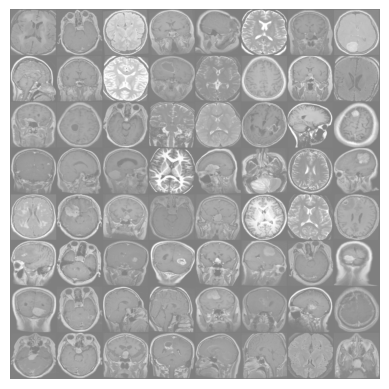

2 3 2 3 0 2 3 1 3 3 2 0 2 1 3 2 1 0 3 2 2 0 2 1 0 3 1 2 1 2 2 1 2 1 3 3 3 2 2 2 0 3 0 0 1 1 3 1 1 3 3 3 1 0 0 0 1 3 3 0 0 3 2 3


In [4]:
# Function to show an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis("off")
    plt.show()

# Get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show images
imshow(tv.utils.make_grid(images))

# Print labels
print(' '.join(f'{labels[j]}' for j in range(len(labels))))

In [5]:
class CNN_Alex_mod(th.nn.Module):
    def __init__(self, cls_out: int = 4) -> None:
        super().__init__()
        
        self.conv = th.nn.Sequential(
            th.nn.Conv2d(
                in_channels=3, out_channels=96, kernel_size=9, stride=4, padding=0
            ),
            th.nn.BatchNorm2d(96),
            th.nn.Mish(),
            th.nn.MaxPool2d(kernel_size=2),
            th.nn.Conv2d(
                in_channels=96, out_channels=256, kernel_size=5, stride=1, padding=0
            ),
            th.nn.BatchNorm2d(256),
            th.nn.Mish(),
            th.nn.MaxPool2d(kernel_size=2),
            th.nn.Conv2d(
                in_channels=256, out_channels=384, kernel_size=3, stride=1, padding=1
            ),
            th.nn.BatchNorm2d(384),
            th.nn.Mish(),
            #th.nn.Conv2d(
            #    in_channels=384, out_channels=384, kernel_size=3, stride=1, padding=1
            #),
            #th.nn.BatchNorm2d(384),
            #th.nn.Mish(),
            th.nn.Conv2d(
                in_channels=384, out_channels=256, kernel_size=3, stride=1, padding=1
            ),
            th.nn.BatchNorm2d(256),
            th.nn.Mish(),
            th.nn.MaxPool2d(kernel_size=2),
            th.nn.Flatten(),
        )

        self.head = th.nn.Sequential(
            th.nn.Linear(1024, 512),
            th.nn.Mish(),
            th.nn.Dropout(p=0.4),
            #th.nn.Linear(512, 512),
            #th.nn.Mish(),
            #th.nn.Dropout(p=0.3),
            th.nn.Linear(512, 128),
            th.nn.Mish(),
            th.nn.Dropout(p=0.4),
            th.nn.Linear(128, cls_out),
            #th.nn.Softmax(dim=1),
        )

    def forward(self, x: Tensor) -> Tensor:
        return self.head(self.conv(x))

In [6]:
model: CNN_Alex_mod = CNN_Alex_mod().to(device)
model.train()

CNN_Alex_mod(
  (conv): Sequential(
    (0): Conv2d(3, 96, kernel_size=(9, 9), stride=(4, 4))
    (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Mish()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1))
    (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Mish()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Mish()
    (11): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): Mish()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Fl

In [7]:
# Let's define the optimizer
optimizer: th.optim.Optimizer = th.optim.Adam(
    params=model.parameters(), lr=LR, weight_decay=1e-5 # L2 regularization
)

# Let's define the learning rate scheduler
scheduler = StepLR(optimizer, step_size=10, gamma=0.5)

In [8]:
eval_losses: List[float] = []
eval_acc: List[float] = []
test_acc: List[float] = []
confidence_scores: List[float] = []

# Loop over epochs
for epoch in trange(EPOCHS, desc="Training epoch"):

    model.train()  # Remember to set the model in training mode before actual training

    # Loop over data
    for batch_idx, batched_datapoint in enumerate(train_loader):

        x, y = batched_datapoint
        x, y = x.to(device), y.to(device)

        # Forward pass + loss computation
        yhat = model(x)
        loss = CRITERION(yhat, y)

        # Zero-out past gradients
        optimizer.zero_grad()

        # Backward pass
        loss.backward()

        # Update model parameters
        optimizer.step()
        
    # Step the scheduler
    scheduler.step()

    # Log the loss and accuracy on the training set...
    num_elem: int = 0
    trackingmetric: float = 0
    trackingcorrect: int = 0

    model.eval()  # Remember to set the model in evaluation mode before evaluating it

    # Since we are just evaluating the model, we don't need to compute gradients
    with th.no_grad():
        # ... by looping over training data again
        for _, batched_datapoint_e in enumerate(train_loader):
            x_e, y_e = batched_datapoint_e
            x_e, y_e = x_e.to(device), y_e.to(device)
            modeltarget_e = model(x_e)
            softmax_probs = th.nn.functional.softmax(modeltarget_e, dim=1)
            ypred_e = th.argmax(modeltarget_e, dim=1, keepdim=True)
            trackingmetric += EVAL_CRITERION(modeltarget_e, y_e).item()
            trackingcorrect += ypred_e.eq(y_e.view_as(ypred_e)).sum().item()
            num_elem += x_e.shape[0]
        eval_losses.append(trackingmetric / num_elem)
        eval_acc.append(trackingcorrect / num_elem)
        confidence_scores.append(softmax_probs.max(dim=1).values.mean())

Training epoch: 100%|██████████| 40/40 [27:13<00:00, 40.85s/it]


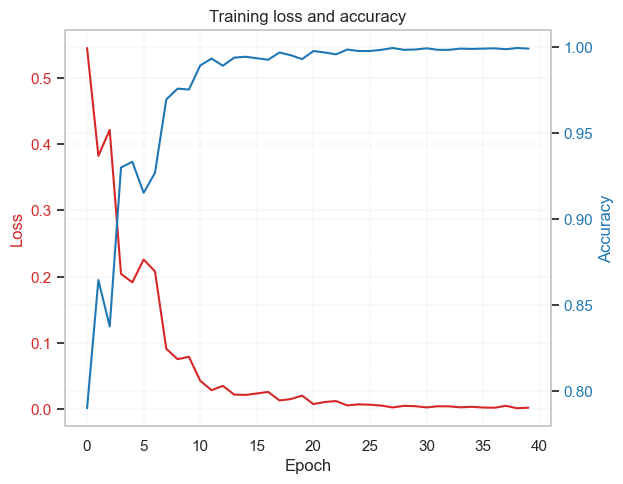

In [9]:
loss_color = "tab:red"
acc_color = "tab:blue"

fig, ax1 = plt.subplots()

ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss", color=loss_color)
ax1.plot(eval_losses, color=loss_color)
ax1.tick_params(axis="y", labelcolor=loss_color)

ax2 = ax1.twinx()
ax2.set_ylabel("Accuracy", color=acc_color)
ax2.plot(eval_acc, color=acc_color)
ax2.tick_params(axis="y", labelcolor=acc_color)

fig.tight_layout()

plt.title("Training loss and accuracy")
plt.show()

In [10]:
print(f"Final training loss: {eval_losses[-1]}")
print(f"Final training accuracy: {eval_acc[-1]}")

Final training loss: 0.00258538406097698
Final training accuracy: 0.9992997198879552


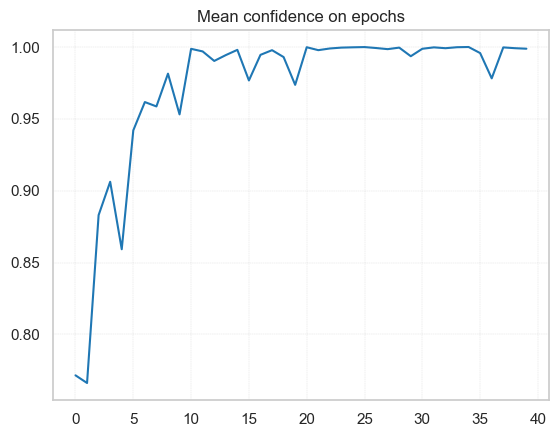

In [11]:
confidence_scores = [tensor.item() for tensor in confidence_scores]

plt.title("Mean confidence on epochs")
plt.plot(confidence_scores)
plt.show()

In [12]:
print(f"Final confidence on last epoch(training): {confidence_scores[-1]}")

Final confidence on last epoch(training): 0.9987380504608154


In [13]:
# Evaluate the model on the test set
model.eval()  # Remember to set the model in evaluation mode before evaluating it

num_elem: int = 0
trackingcorrect: int = 0

# Since we are just evaluating the model, we don't need to compute gradients
with th.no_grad():
    # Loop over test data
    for _, batched_datapoint_e in enumerate(test_loader):
        x_e, y_e = batched_datapoint_e
        x_e, y_e = x_e.to(device), y_e.to(device)
        modeltarget_e = model(x_e)
        softmax_probs = th.nn.functional.softmax(modeltarget_e, dim=1)
        ypred_e = th.argmax(modeltarget_e, dim=1, keepdim=True)
        trackingcorrect += ypred_e.eq(y_e.view_as(ypred_e)).sum().item()
        num_elem += x_e.shape[0]
    test_acc.append(trackingcorrect / num_elem)
    confidence_scores.append(softmax_probs.max(dim=1).values.mean())
    
print(f"Final test accuracy: {test_acc[-1]}")
print(f"Final confidence on test set: {confidence_scores[-1]}")

Final test accuracy: 0.9816933638443935
Final confidence on test set: 0.9999071955680847


### FIRST LAYER

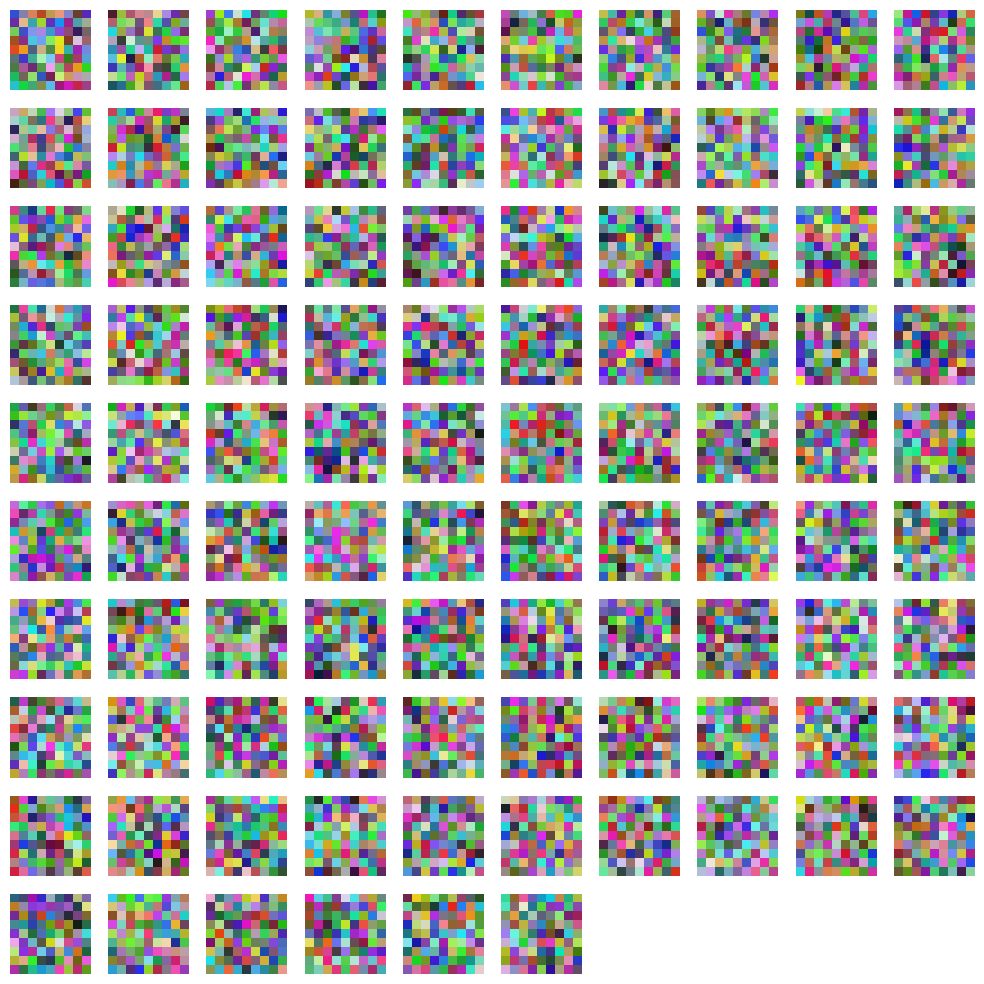

In [14]:
conv1_weights = model.conv[0].weight.data.cpu()

# Normalize
min_weight = conv1_weights.min()
max_weight = conv1_weights.max()
normalized_weights = (conv1_weights - min_weight) / (max_weight - min_weight)

# Number of kernels to be visualized
num_kernels = normalized_weights.shape[0]

plt.figure(figsize=(10, 10))

for i in range(num_kernels):
    plt.subplot(10, 10, i + 1) 
    kernel = normalized_weights[i].permute(1, 2, 0)  # Make the weights compatible with matplotlib
    
    plt.imshow(kernel)  #RGB

    plt.axis('off')
plt.tight_layout()
plt.show()

### SECOND LAYER

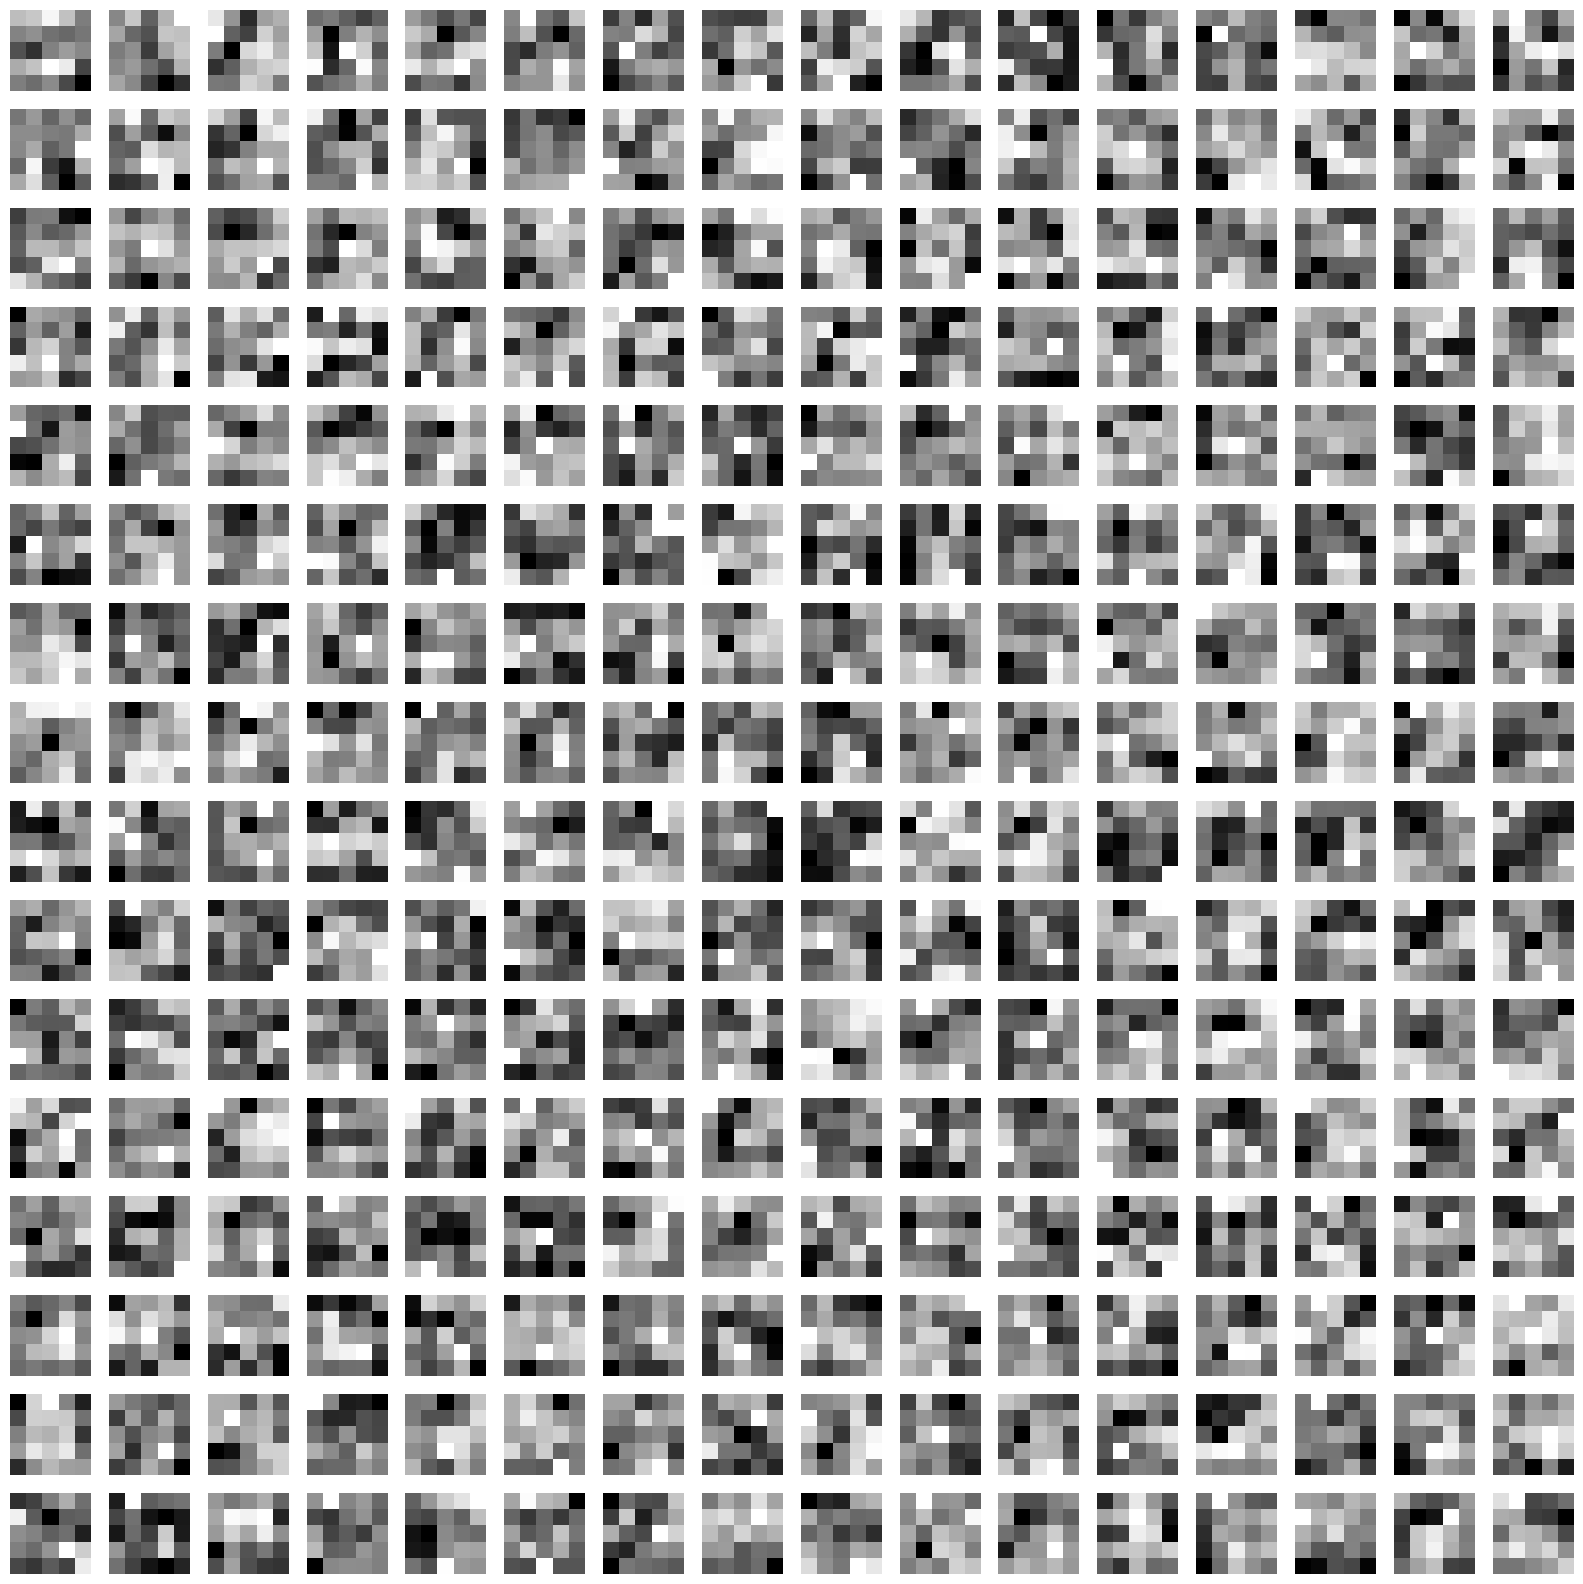

In [15]:
conv2_weights = model.conv[4].weight.data.cpu()

# Average the filter weights across the input channels (64 input channels)
avg_weights = conv2_weights.mean(dim=1)  

# Normalize the weights for better visualization
min_weight = avg_weights.min(dim=0, keepdim=True)[0]
max_weight = avg_weights.max(dim=0, keepdim=True)[0]
normalized_weights = (avg_weights - min_weight) / (max_weight - min_weight)  # Dimension (128, 3, 3)

# Visualize the filters
num_kernels = normalized_weights.shape[0]  

plt.figure(figsize=(16, 16))  

for i in range(num_kernels):
    plt.subplot(16, 16, i + 1) 
    kernel = normalized_weights[i].cpu().numpy()  # Get the i-th normalized kernel
    plt.imshow(kernel, cmap='gray')
    plt.axis('off')

plt.tight_layout()
plt.show()

### LAST LAYER

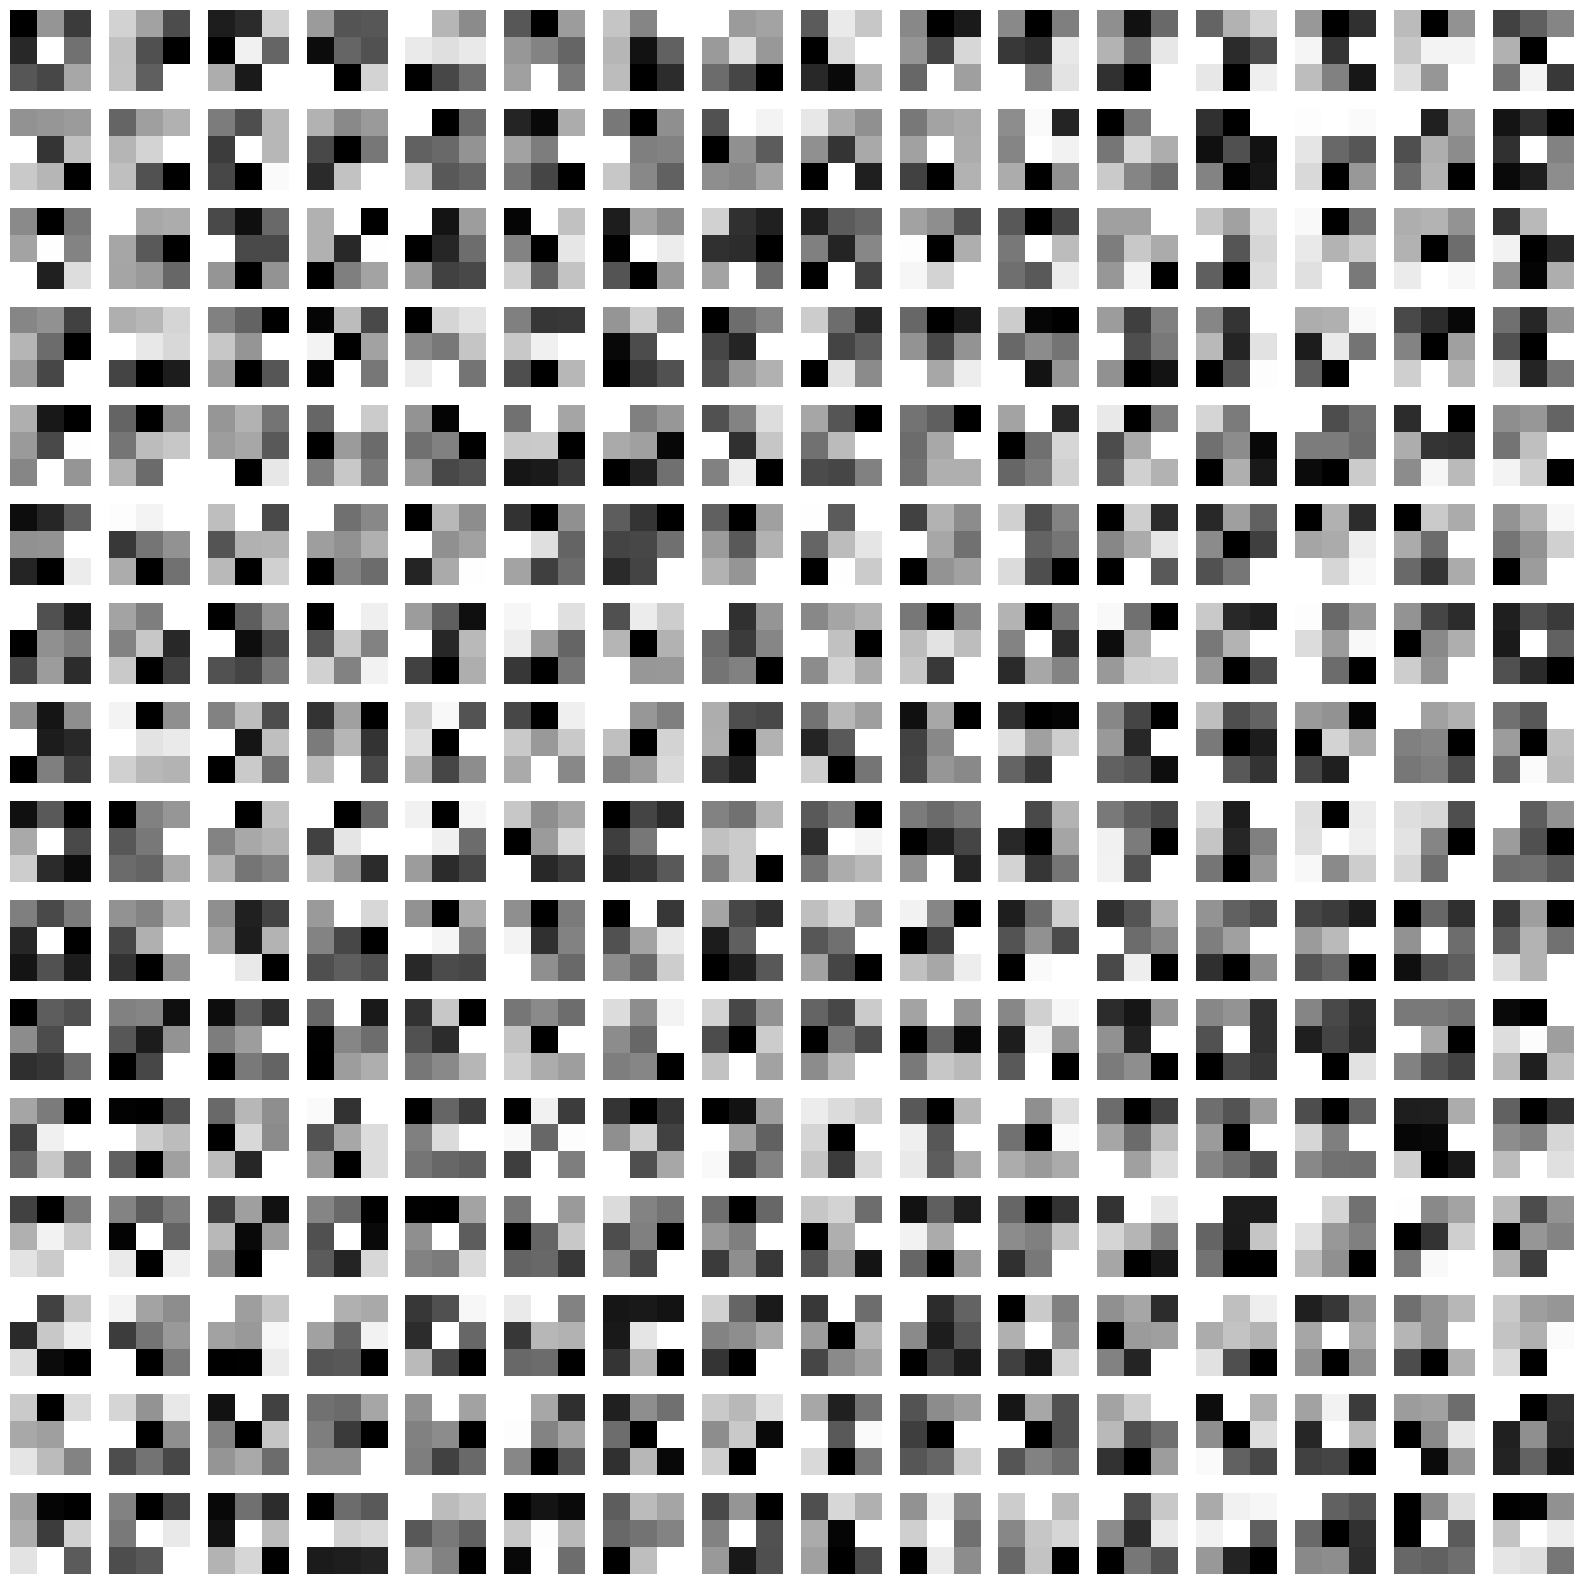

In [16]:
conv_last_weights = model.conv[11].weight.data.cpu()

# Average the filter weights across the input channels (64 input channels)
avg_weights = conv_last_weights.mean(dim=1)  

# Normalize the weights for better visualization
min_weight = avg_weights.min(dim=0, keepdim=True)[0]
max_weight = avg_weights.max(dim=0, keepdim=True)[0]
normalized_weights = (avg_weights - min_weight) / (max_weight - min_weight)  # Dimension (128, 3, 3)

# Visualize the filters
num_kernels = normalized_weights.shape[0]  

plt.figure(figsize=(16, 16))  

for i in range(num_kernels):
    plt.subplot(16, 16, i + 1) 
    kernel = normalized_weights[i].cpu().numpy()  # Get the i-th normalized kernel
    plt.imshow(kernel, cmap='gray')
    plt.axis('off')

plt.tight_layout()
plt.show()

# With basic AlexNet

In [17]:
# Define the transformations for the training and testing datasets
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize images to 128x128
    transforms.ToTensor(),          # Convert images to PyTorch tensors
])

# Define the paths to the training and testing datasets
train_dir = 'datasets/cleaned/Training'
test_dir = 'datasets/cleaned/Testing'

# Create the datasets
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

# Create the DataLoaders
train_loader: DataLoader = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=TEST_BS, shuffle=False)

# Use only a small subset of the data for training to test the model
#test_train_dataset = th.utils.data.Subset(train_dataset, np.random.choice(len(train_dataset), 500))
#train_loader = DataLoader(test_train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True)

# Example of iterating through the DataLoader
for images, labels in train_loader:
    print(images.shape, labels.shape)
    break

torch.Size([64, 3, 128, 128]) torch.Size([64])


In [18]:
class CNN_Alex(th.nn.Module):
    def __init__(self, cls_out: int = 4) -> None:
        super().__init__()
        
        self.conv = th.nn.Sequential(
            th.nn.Conv2d(
                in_channels=3, out_channels=96, kernel_size=9, stride=4, padding=0
            ),
            #th.nn.BatchNorm2d(96),
            th.nn.ReLU(),
            th.nn.MaxPool2d(kernel_size=2),
            th.nn.Conv2d(
                in_channels=96, out_channels=256, kernel_size=5, stride=1, padding=0
            ),
            #th.nn.BatchNorm2d(256),
            th.nn.ReLU(),
            th.nn.MaxPool2d(kernel_size=2),
            th.nn.Conv2d(
                in_channels=256, out_channels=384, kernel_size=3, stride=1, padding=1
            ),
            #th.nn.BatchNorm2d(384),
            th.nn.ReLU(),
            th.nn.Conv2d(
                in_channels=384, out_channels=384, kernel_size=3, stride=1, padding=1
            ),
            #th.nn.BatchNorm2d(384),
            th.nn.ReLU(),
            th.nn.Conv2d(
                in_channels=384, out_channels=256, kernel_size=3, stride=1, padding=1
            ),
            #th.nn.BatchNorm2d(256),
            th.nn.ReLU(),
            th.nn.MaxPool2d(kernel_size=2),
            th.nn.Flatten(),
        )

        self.head = th.nn.Sequential(
            th.nn.Linear(1024, 512),
            th.nn.ReLU(),
            th.nn.Dropout(p=0.4),
            th.nn.Linear(512, 512),
            th.nn.ReLU(),
            #th.nn.Dropout(p=0.3),
            th.nn.Linear(512, 128),
            th.nn.ReLU(),
            #th.nn.Dropout(p=0.4),
            th.nn.Linear(128, cls_out),
            #th.nn.Softmax(dim=1),
        )

    def forward(self, x: Tensor) -> Tensor:
        return self.head(self.conv(x))

In [19]:
modela: CNN_Alex = CNN_Alex().to(device)
modela.train()

CNN_Alex(
  (conv): Sequential(
    (0): Conv2d(3, 96, kernel_size=(9, 9), stride=(4, 4))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (13): Flatten(start_dim=1, end_dim=-1)
  )
  (head): Sequential(
    (0): Linear(in_features=1024, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4, inplace=False)
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): ReLU()
    (5): Linear(in_

In [20]:
# Let's define the optimizer
optimizer: th.optim.Optimizer = th.optim.Adam(
    params=modela.parameters(), lr=LR
)

In [21]:
eval_losses: List[float] = []
eval_acc: List[float] = []
test_acc: List[float] = []
confidence_scores: List[float] = []

# Loop over epochs
for epoch in trange(EPOCHS, desc="Training epoch"):

    modela.train()  # Remember to set the model in training mode before actual training

    # Loop over data
    for batch_idx, batched_datapoint in enumerate(train_loader):

        x, y = batched_datapoint
        x, y = x.to(device), y.to(device)

        # Forward pass + loss computation
        yhat = modela(x)
        loss = CRITERION(yhat, y)

        # Zero-out past gradients
        optimizer.zero_grad()

        # Backward pass
        loss.backward()

        # Update model parameters
        optimizer.step()

    # Log the loss and accuracy on the training set...
    num_elem: int = 0
    trackingmetric: float = 0
    trackingcorrect: int = 0

    modela.eval()  # Remember to set the model in evaluation mode before evaluating it

    # Since we are just evaluating the model, we don't need to compute gradients
    with th.no_grad():
        # ... by looping over training data again
        for _, batched_datapoint_e in enumerate(train_loader):
            x_e, y_e = batched_datapoint_e
            x_e, y_e = x_e.to(device), y_e.to(device)
            modeltarget_e = modela(x_e)
            softmax_probs = th.nn.functional.softmax(modeltarget_e, dim=1)
            ypred_e = th.argmax(modeltarget_e, dim=1, keepdim=True)
            trackingmetric += EVAL_CRITERION(modeltarget_e, y_e).item()
            trackingcorrect += ypred_e.eq(y_e.view_as(ypred_e)).sum().item()
            num_elem += x_e.shape[0]
        eval_losses.append(trackingmetric / num_elem)
        eval_acc.append(trackingcorrect / num_elem)
        confidence_scores.append(softmax_probs.max(dim=1).values.mean())


Training epoch: 100%|██████████| 40/40 [15:24<00:00, 23.11s/it]


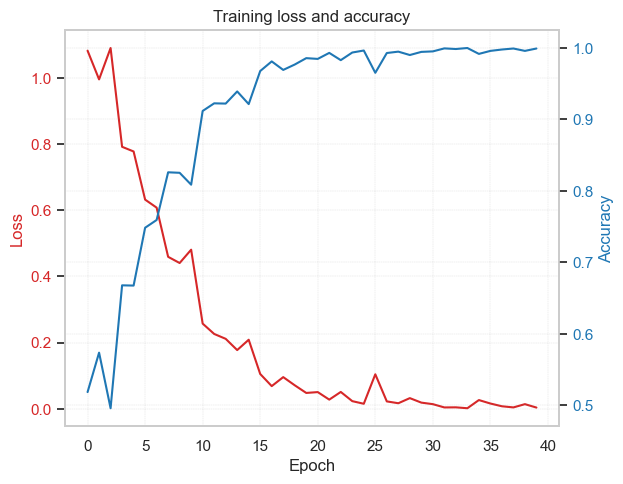

In [22]:
loss_color = "tab:red"
acc_color = "tab:blue"

fig, ax1 = plt.subplots()

ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss", color=loss_color)
ax1.plot(eval_losses, color=loss_color)
ax1.tick_params(axis="y", labelcolor=loss_color)

ax2 = ax1.twinx()
ax2.set_ylabel("Accuracy", color=acc_color)
ax2.plot(eval_acc, color=acc_color)
ax2.tick_params(axis="y", labelcolor=acc_color)

fig.tight_layout()

plt.title("Training loss and accuracy")
plt.show()

In [23]:
print(f"Final training loss: {eval_losses[-1]}")
print(f"Final training accuracy: {eval_acc[-1]}")

Final training loss: 0.0038268504982568972
Final training accuracy: 0.999124649859944


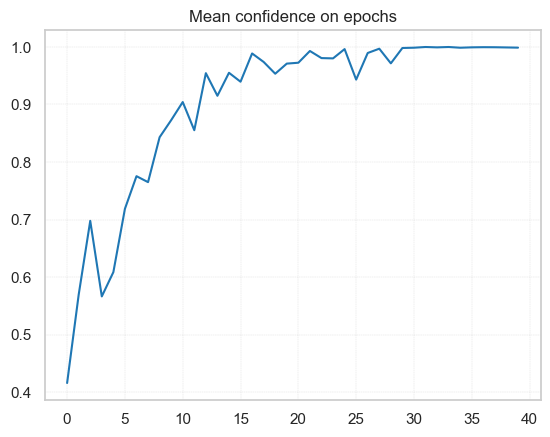

In [24]:
confidence_scores = [tensor.item() for tensor in confidence_scores]

plt.title("Mean confidence on epochs")
plt.plot(confidence_scores)
plt.show()

In [25]:
print(f"Final confidence on last epoch(training): {confidence_scores[-1]}")

Final confidence on last epoch(training): 0.9987399578094482


In [26]:
# Evaluate the model on the test set
modela.eval()  # Remember to set the model in evaluation mode before evaluating it

num_elem: int = 0
trackingcorrect: int = 0

# Since we are just evaluating the model, we don't need to compute gradients
with th.no_grad():
    # Loop over test data
    for _, batched_datapoint_e in enumerate(test_loader):
        x_e, y_e = batched_datapoint_e
        x_e, y_e = x_e.to(device), y_e.to(device)
        modeltarget_e = modela(x_e)
        softmax_probs = th.nn.functional.softmax(modeltarget_e, dim=1)
        ypred_e = th.argmax(modeltarget_e, dim=1, keepdim=True)
        trackingcorrect += ypred_e.eq(y_e.view_as(ypred_e)).sum().item()
        num_elem += x_e.shape[0]
    test_acc.append(trackingcorrect / num_elem)
    confidence_scores.append(softmax_probs.max(dim=1).values.mean())
    
print(f"Final test accuracy: {test_acc[-1]}")
print(f"Final confidence on test set: {confidence_scores[-1]}")

Final test accuracy: 0.9298245614035088
Final confidence on test set: 0.997566819190979


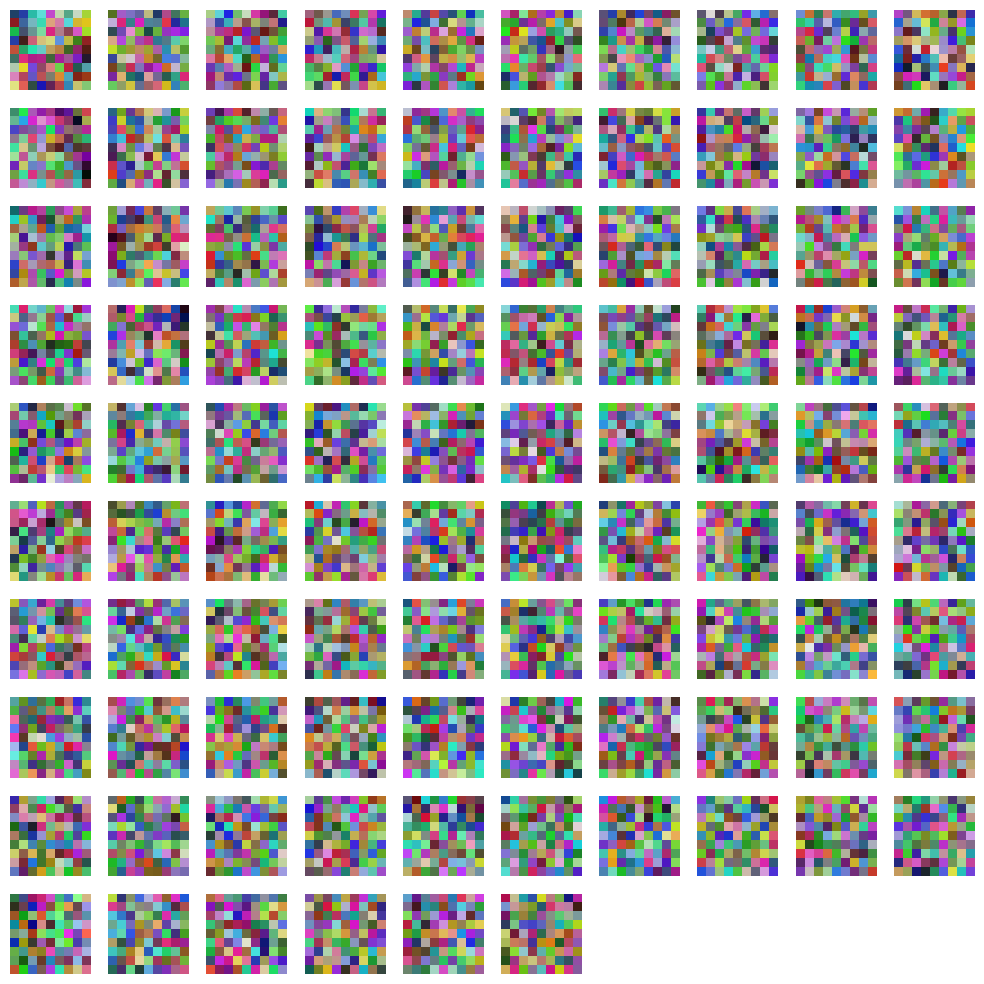

In [27]:
conv1_weights = modela.conv[0].weight.data.cpu()

# Normalize
min_weight = conv1_weights.min()
max_weight = conv1_weights.max()
normalized_weights = (conv1_weights - min_weight) / (max_weight - min_weight)

# Number of kernels to be visualized
num_kernels = normalized_weights.shape[0]

plt.figure(figsize=(10, 10))

for i in range(num_kernels):
    plt.subplot(10, 10, i + 1) 
    kernel = normalized_weights[i].permute(1, 2, 0)  # Make the weights compatible with matplotlib
    
    plt.imshow(kernel)  #RGB

    plt.axis('off')
plt.tight_layout()
plt.show()

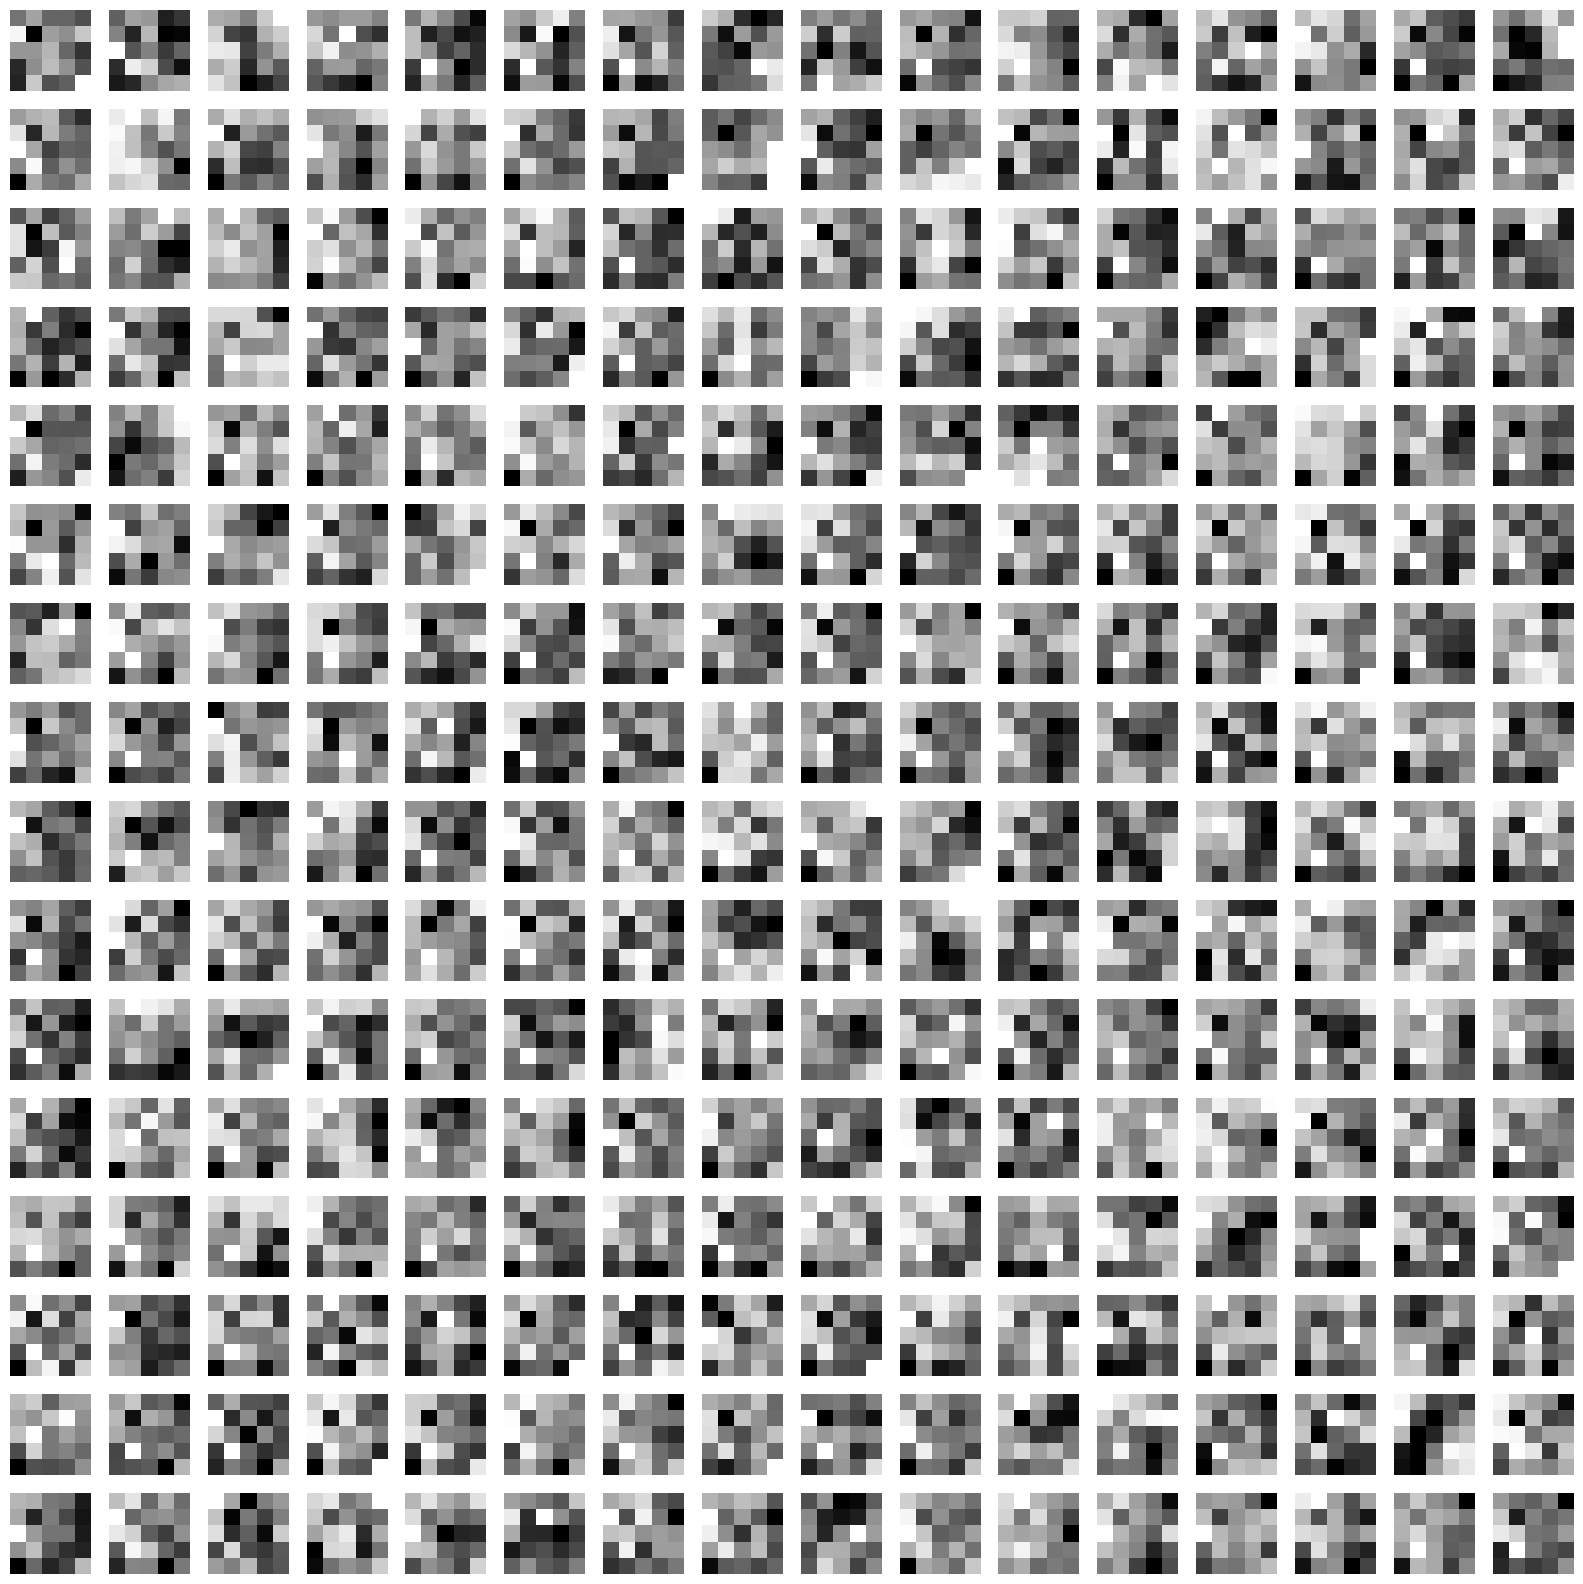

In [28]:
conv2_weights = modela.conv[3].weight.data.cpu()

# Average the filter weights across the input channels (64 input channels)
avg_weights = conv2_weights.mean(dim=1)  

# Normalize the weights for better visualization
min_weight = avg_weights.min(dim=0, keepdim=True)[0]
max_weight = avg_weights.max(dim=0, keepdim=True)[0]
normalized_weights = (avg_weights - min_weight) / (max_weight - min_weight)  # Dimension (128, 3, 3)

# Visualize the filters
num_kernels = normalized_weights.shape[0]  

plt.figure(figsize=(16, 16))  

for i in range(num_kernels):
    plt.subplot(16, 16, i + 1) 
    kernel = normalized_weights[i].cpu().numpy()  # Get the i-th normalized kernel
    plt.imshow(kernel, cmap='gray')
    plt.axis('off')

plt.tight_layout()
plt.show()

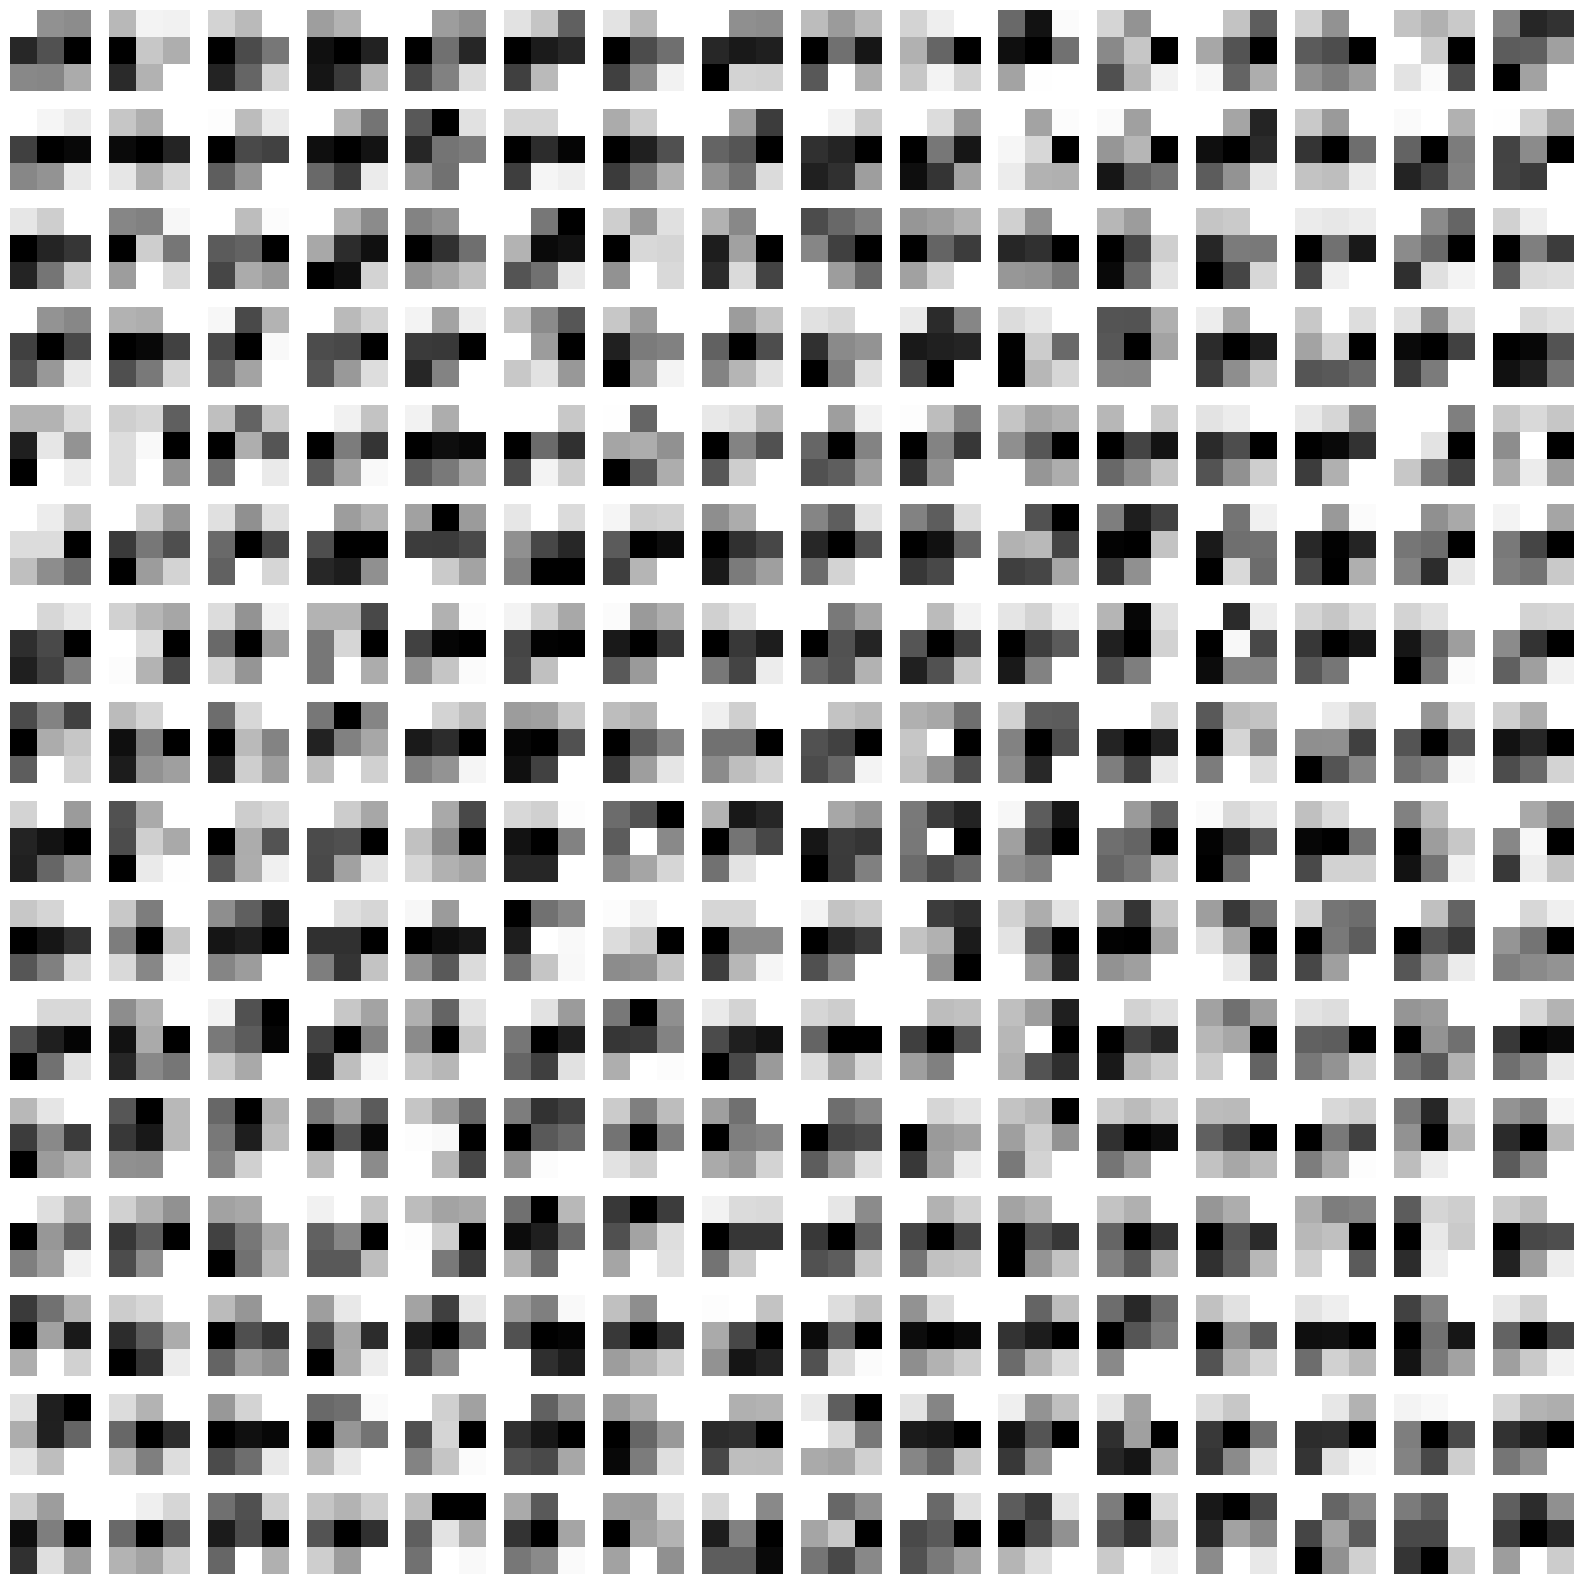

In [29]:
conv_last_weights = modela.conv[10].weight.data.cpu()

# Average the filter weights across the input channels (64 input channels)
avg_weights = conv_last_weights.mean(dim=1)  

# Normalize the weights for better visualization
min_weight = avg_weights.min(dim=0, keepdim=True)[0]
max_weight = avg_weights.max(dim=0, keepdim=True)[0]
normalized_weights = (avg_weights - min_weight) / (max_weight - min_weight)  # Dimension (128, 3, 3)

# Visualize the filters
num_kernels = normalized_weights.shape[0]  

plt.figure(figsize=(16, 16))  

for i in range(num_kernels):
    plt.subplot(16, 16, i + 1) 
    kernel = normalized_weights[i].cpu().numpy()  # Get the i-th normalized kernel
    plt.imshow(kernel, cmap='gray')
    plt.axis('off')

plt.tight_layout()
plt.show()

# With VGG16

In [30]:
class VGG16_128(th.nn.Module):
    def __init__(self, num_classes: int = 4) -> None:
        super(VGG16_128, self).__init__()
        
        self.conv_layers = th.nn.Sequential(
            # Block 1
            th.nn.Conv2d(3, 64, kernel_size=3, padding=1),
            th.nn.ReLU(inplace=True),
            th.nn.Conv2d(64, 64, kernel_size=3, padding=1),
            th.nn.ReLU(inplace=True),
            th.nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Block 2
            th.nn.Conv2d(64, 128, kernel_size=3, padding=1),
            th.nn.ReLU(inplace=True),
            th.nn.Conv2d(128, 128, kernel_size=3, padding=1),
            th.nn.ReLU(inplace=True),
            th.nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Block 3
            th.nn.Conv2d(128, 256, kernel_size=3, padding=1),
            th.nn.ReLU(inplace=True),
            th.nn.Conv2d(256, 256, kernel_size=3, padding=1),
            th.nn.ReLU(inplace=True),
            th.nn.Conv2d(256, 256, kernel_size=3, padding=1),
            th.nn.ReLU(inplace=True),
            th.nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Block 4
            th.nn.Conv2d(256, 512, kernel_size=3, padding=1),
            th.nn.ReLU(inplace=True),
            th.nn.Conv2d(512, 512, kernel_size=3, padding=1),
            th.nn.ReLU(inplace=True),
            th.nn.Conv2d(512, 512, kernel_size=3, padding=1),
            th.nn.ReLU(inplace=True),
            th.nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Block 5
            th.nn.Conv2d(512, 512, kernel_size=3, padding=1),
            th.nn.ReLU(inplace=True),
            th.nn.Conv2d(512, 512, kernel_size=3, padding=1),
            th.nn.ReLU(inplace=True),
            th.nn.Conv2d(512, 512, kernel_size=3, padding=1),
            th.nn.ReLU(inplace=True),
            th.nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        self.fc_layers = th.nn.Sequential(
            th.nn.Linear(512 * 4 * 4, 4096),  # Adjusted for 128x128 input size
            th.nn.ReLU(inplace=True),
            th.nn.Dropout(p=0.5),
            th.nn.Linear(4096, 4096),
            th.nn.ReLU(inplace=True),
            th.nn.Dropout(p=0.5),
            th.nn.Linear(4096, num_classes),
            #th.nn.Softmax(dim=1),
        )
    
    def forward(self, x: Tensor) -> Tensor:
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.fc_layers(x)
        return x

In [31]:
modelv: VGG16_128 = VGG16_128().to(device)
modelv.train()

VGG16_128(
  (conv_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, d

In [32]:
# Let's define the optimizer
optimizer: th.optim.Optimizer = th.optim.Adam(
    params=modelv.parameters(), lr=LR
)

In [33]:
eval_losses: List[float] = []
eval_acc: List[float] = []
test_acc: List[float] = []
confidence_scores: List[float] = []

# Loop over epochs
for epoch in trange(EPOCHS, desc="Training epoch"):

    modelv.train()  # Remember to set the model in training mode before actual training

    # Loop over data
    for batch_idx, batched_datapoint in enumerate(train_loader):

        x, y = batched_datapoint
        x, y = x.to(device), y.to(device)

        # Forward pass + loss computation
        yhat = modelv(x)
        loss = CRITERION(yhat, y)

        # Zero-out past gradients
        optimizer.zero_grad()

        # Backward pass
        loss.backward()

        # Update model parameters
        optimizer.step()

    # Log the loss and accuracy on the training set...
    num_elem: int = 0
    trackingmetric: float = 0
    trackingcorrect: int = 0

    modelv.eval()  # Remember to set the model in evaluation mode before evaluating it

    # Since we are just evaluating the model, we don't need to compute gradients
    with th.no_grad():
        # ... by looping over training data again
        for _, batched_datapoint_e in enumerate(train_loader):
            x_e, y_e = batched_datapoint_e
            x_e, y_e = x_e.to(device), y_e.to(device)
            modeltarget_e = modelv(x_e)
            softmax_probs = th.nn.functional.softmax(modeltarget_e, dim=1)
            ypred_e = th.argmax(modeltarget_e, dim=1, keepdim=True)
            trackingmetric += EVAL_CRITERION(modeltarget_e, y_e).item()
            trackingcorrect += ypred_e.eq(y_e.view_as(ypred_e)).sum().item()
            num_elem += x_e.shape[0]
        eval_losses.append(trackingmetric / num_elem)
        eval_acc.append(trackingcorrect / num_elem)
        confidence_scores.append(softmax_probs.max(dim=1).values.mean())


Training epoch: 100%|██████████| 40/40 [1:41:44<00:00, 152.62s/it]


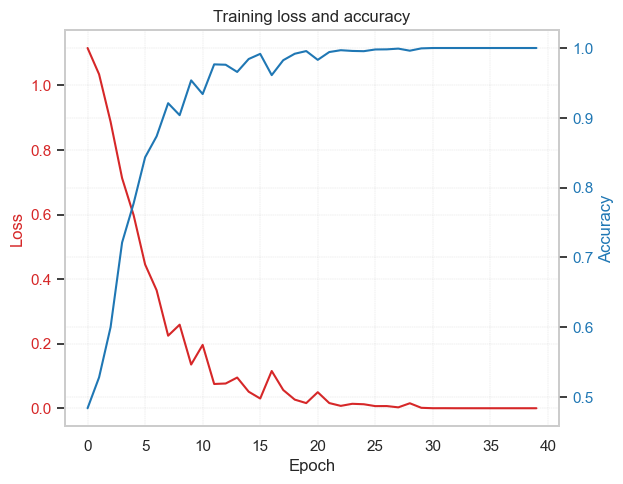

In [34]:
loss_color = "tab:red"
acc_color = "tab:blue"

fig, ax1 = plt.subplots()

ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss", color=loss_color)
ax1.plot(eval_losses, color=loss_color)
ax1.tick_params(axis="y", labelcolor=loss_color)

ax2 = ax1.twinx()
ax2.set_ylabel("Accuracy", color=acc_color)
ax2.plot(eval_acc, color=acc_color)
ax2.tick_params(axis="y", labelcolor=acc_color)

fig.tight_layout()

plt.title("Training loss and accuracy")
plt.show()

In [35]:
print(f"Final training loss: {eval_losses[-1]}")
print(f"Final training accuracy: {eval_acc[-1]}")

Final training loss: 2.5542070670067927e-06
Final training accuracy: 1.0


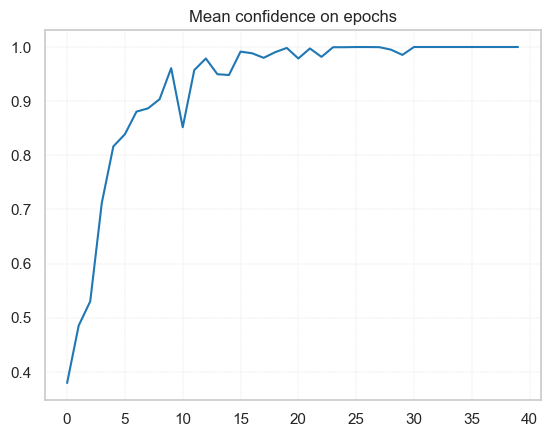

In [36]:
confidence_scores = [tensor.item() for tensor in confidence_scores]

plt.title("Mean confidence on epochs")
plt.plot(confidence_scores)
plt.show()

In [37]:
print(f"Final confidence on last epoch(training): {confidence_scores[-1]}")

Final confidence on last epoch(training): 1.0


In [38]:
# Evaluate the model on the test set
modelv.eval()  # Remember to set the model in evaluation mode before evaluating it

num_elem: int = 0
trackingcorrect: int = 0

# Since we are just evaluating the model, we don't need to compute gradients
with th.no_grad():
    # Loop over test data
    for _, batched_datapoint_e in enumerate(test_loader):
        x_e, y_e = batched_datapoint_e
        x_e, y_e = x_e.to(device), y_e.to(device)
        modeltarget_e = modelv(x_e)
        softmax_probs = th.nn.functional.softmax(modeltarget_e, dim=1)
        ypred_e = th.argmax(modeltarget_e, dim=1, keepdim=True)
        trackingcorrect += ypred_e.eq(y_e.view_as(ypred_e)).sum().item()
        num_elem += x_e.shape[0]
    test_acc.append(trackingcorrect / num_elem)
    confidence_scores.append(softmax_probs.max(dim=1).values.mean())
    
print(f"Final test accuracy: {test_acc[-1]}")
print(f"Final confidence on test set: {confidence_scores[-1]}")

Final test accuracy: 0.9527078565980168
Final confidence on test set: 0.9999521374702454


### FIRST LAYER

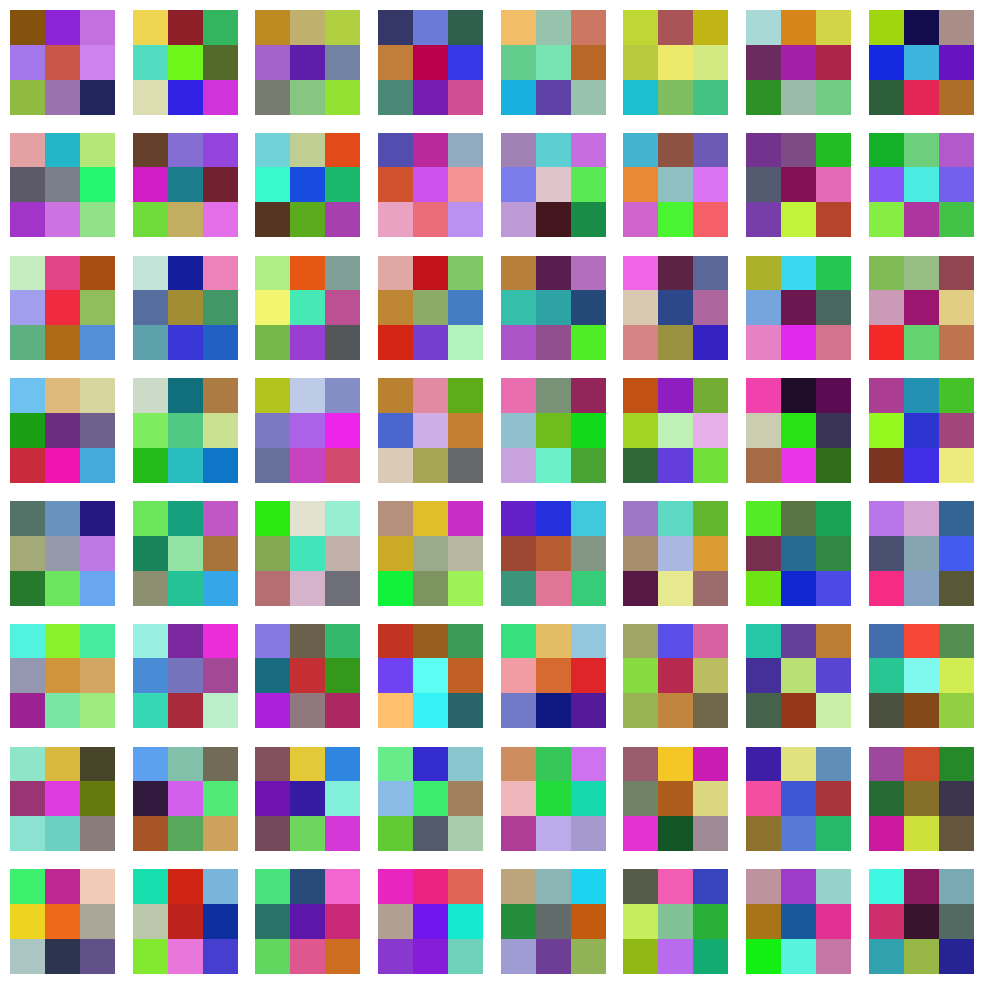

In [39]:
conv1_weights = modelv.conv_layers[0].weight.data.cpu()

# Normalize
min_weight = conv1_weights.min()
max_weight = conv1_weights.max()
normalized_weights = (conv1_weights - min_weight) / (max_weight - min_weight)

# Number of kernels to be visualized
num_kernels = normalized_weights.shape[0]

plt.figure(figsize=(10, 10))

for i in range(num_kernels):
    plt.subplot(8, 8, i + 1) 
    kernel = normalized_weights[i].permute(1, 2, 0)  # Make the weights compatible with matplotlib
    
    plt.imshow(kernel)  #RGB

    plt.axis('off')
plt.tight_layout()
plt.show()

### SECOND LAYER

<function matplotlib.pyplot.tight_layout(*, pad: 'float' = 1.08, h_pad: 'float | None' = None, w_pad: 'float | None' = None, rect: 'tuple[float, float, float, float] | None' = None) -> 'None'>

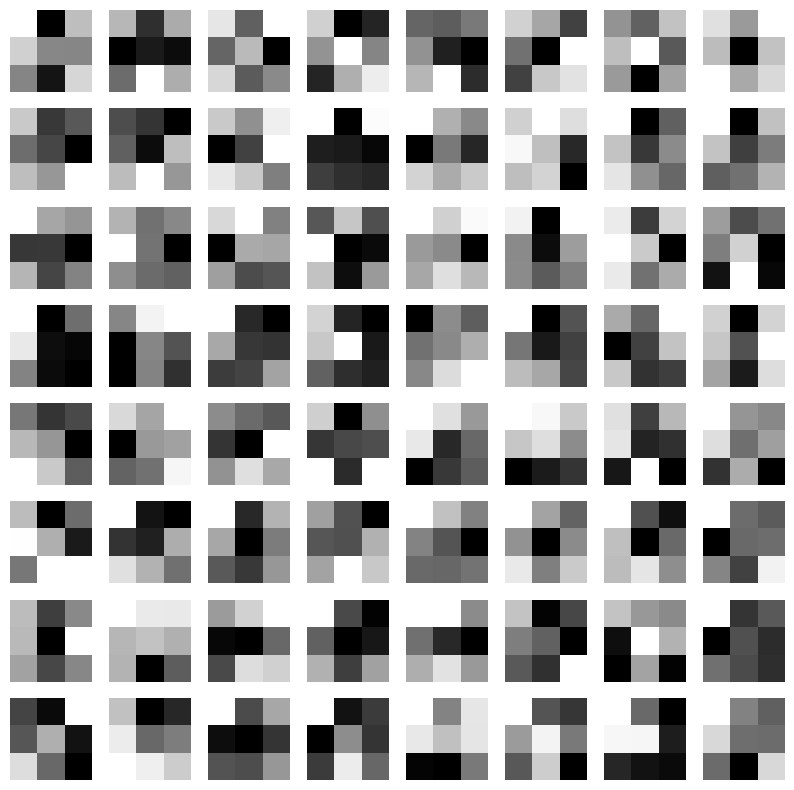

In [40]:
conv2_weights = modelv.conv_layers[2].weight.data.cpu()

# Average the filter weights across the input channels (3 channels)
avg_weights = conv2_weights.mean(dim=1)  # Dimension (64, 3, 3)

# Normalize the weights for better visualization
min_weight = avg_weights.min(dim=0, keepdim=True)[0]
max_weight = avg_weights.max(dim=0, keepdim=True)[0]
normalized_weights = (avg_weights - min_weight) / (max_weight - min_weight)  # Dimension (64, 3, 3)

# Visualize the filters
num_kernels = normalized_weights.shape[0]

plt.figure(figsize=(10, 10))

for i in range(num_kernels):
    plt.subplot(8, 8, i + 1)  # Assuming 64 filters, arrange in 8x8 grid
    kernel = normalized_weights[i].cpu().numpy()  # Get the i-th normalized kernel
    plt.imshow(kernel, cmap='gray')
    plt.axis('off')

plt.tight_layout

### LAST LAYER

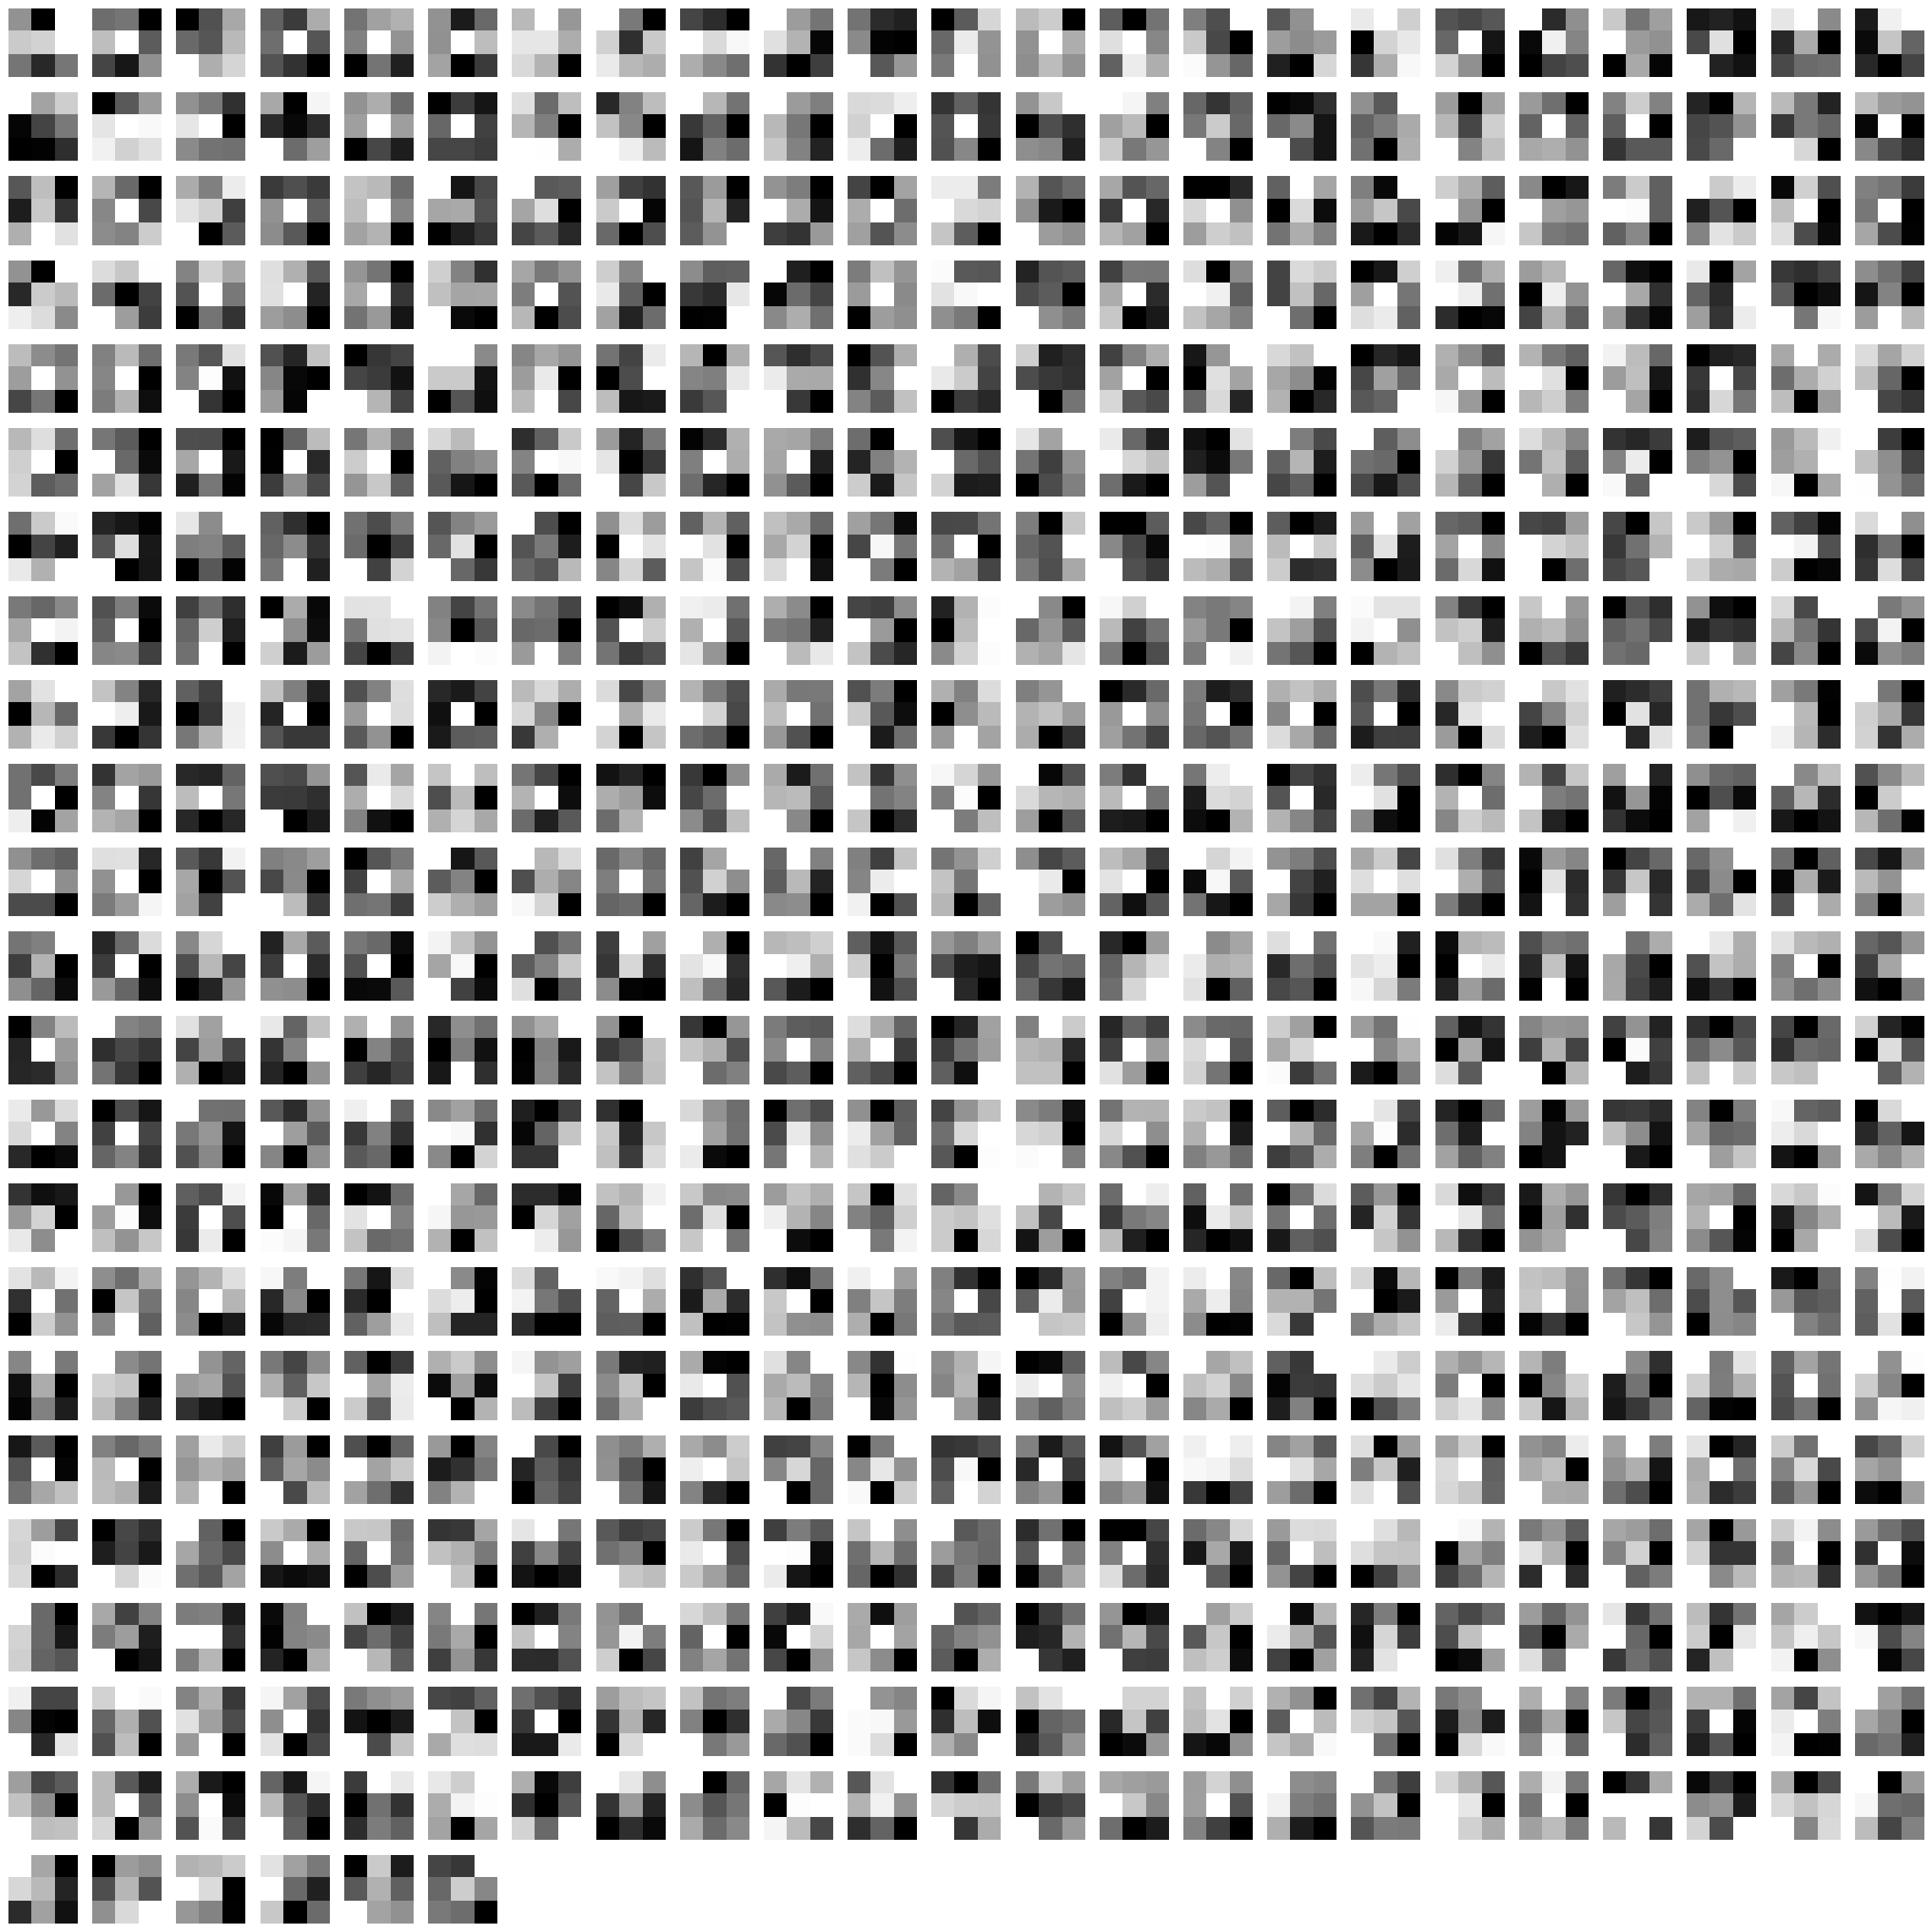

In [41]:
conv_last_weights = modelv.conv_layers[28].weight.data.cpu()

# Average the filter weights across the input channels (512 input channels)
avg_weights = conv_last_weights.mean(dim=1)  # Dimension (512, 3, 3)

# Normalize the weights for better visualization
min_weight = avg_weights.min(dim=0, keepdim=True)[0]
max_weight = avg_weights.max(dim=0, keepdim=True)[0]
normalized_weights = (avg_weights - min_weight) / (max_weight - min_weight)  # Dimension (128, 3, 3)

# Visualize the filters
num_kernels = normalized_weights.shape[0]  # Should be 512 filters

plt.figure(figsize=(23, 23))  # Adjust the figure size for a 23x23 grid

for i in range(num_kernels):
    plt.subplot(23, 23, i + 1)  # 23x23 grid for 512 filters
    kernel = normalized_weights[i].cpu().numpy()  # Get the i-th normalized kernel
    plt.imshow(kernel, cmap='gray')
    plt.axis('off')

plt.tight_layout()
plt.show()

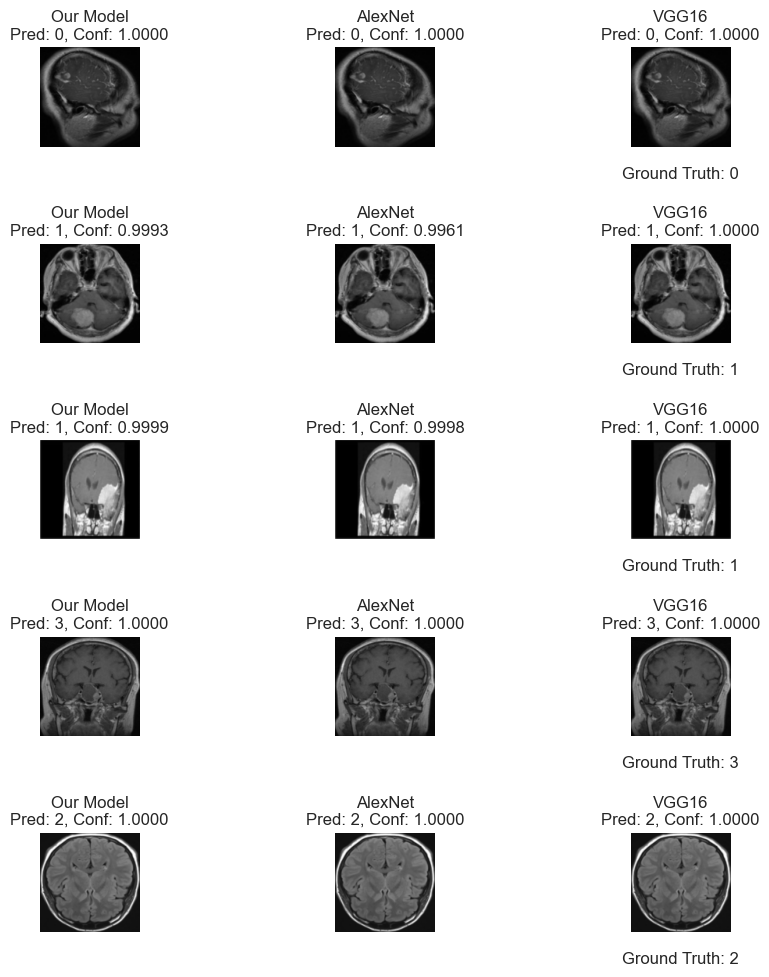

In [42]:
import random
models = [model, modela, modelv]  
model_names = ["Our Model", "AlexNet", "VGG16"]

num_samples = 5

random_indices = random.sample(range(len(test_loader.dataset)), num_samples)
sample_data = [test_loader.dataset[i] for i in random_indices]

fig, axes = plt.subplots(num_samples, len(models), figsize=(10, num_samples * 2))

for i, (x, y) in enumerate(sample_data):
    x_tensor = x.unsqueeze(0).to(device)

    for j, (model, name) in enumerate(zip(models, model_names)):
        with th.no_grad():
            output = model(x_tensor)
            softmax_probs = th.nn.functional.softmax(output, dim=1)
            predicted_label = th.argmax(output, dim=1).item()
            confidence = softmax_probs.max().item()

        axes[i, j].imshow(x.permute(1, 2, 0).cpu())
        axes[i, j].set_title(f"{name}\nPred: {predicted_label}, Conf: {confidence:.4f}")
        axes[i, j].axis('off')

    axes[i, len(models) - 1].text(0.5, -0.2, f"Ground Truth: {y}", ha='center', va='top', transform=axes[i, len(models) - 1].transAxes)

plt.tight_layout()
plt.show()